In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
# Data reference: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting

train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')

In [5]:
dataset = train_df.merge(stores_df, how='left').merge(features_df, how='left')
dataset.head()

Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1  2010-02-05      24924.50      False    A  151315        42.31   
1      1     1  2010-02-12      46039.49       True    A  151315        38.51   
2      1     1  2010-02-19      41595.55      False    A  151315        39.93   
3      1     1  2010-02-26      19403.54      False    A  151315        46.63   
4      1     1  2010-03-05      21827.90      False    A  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

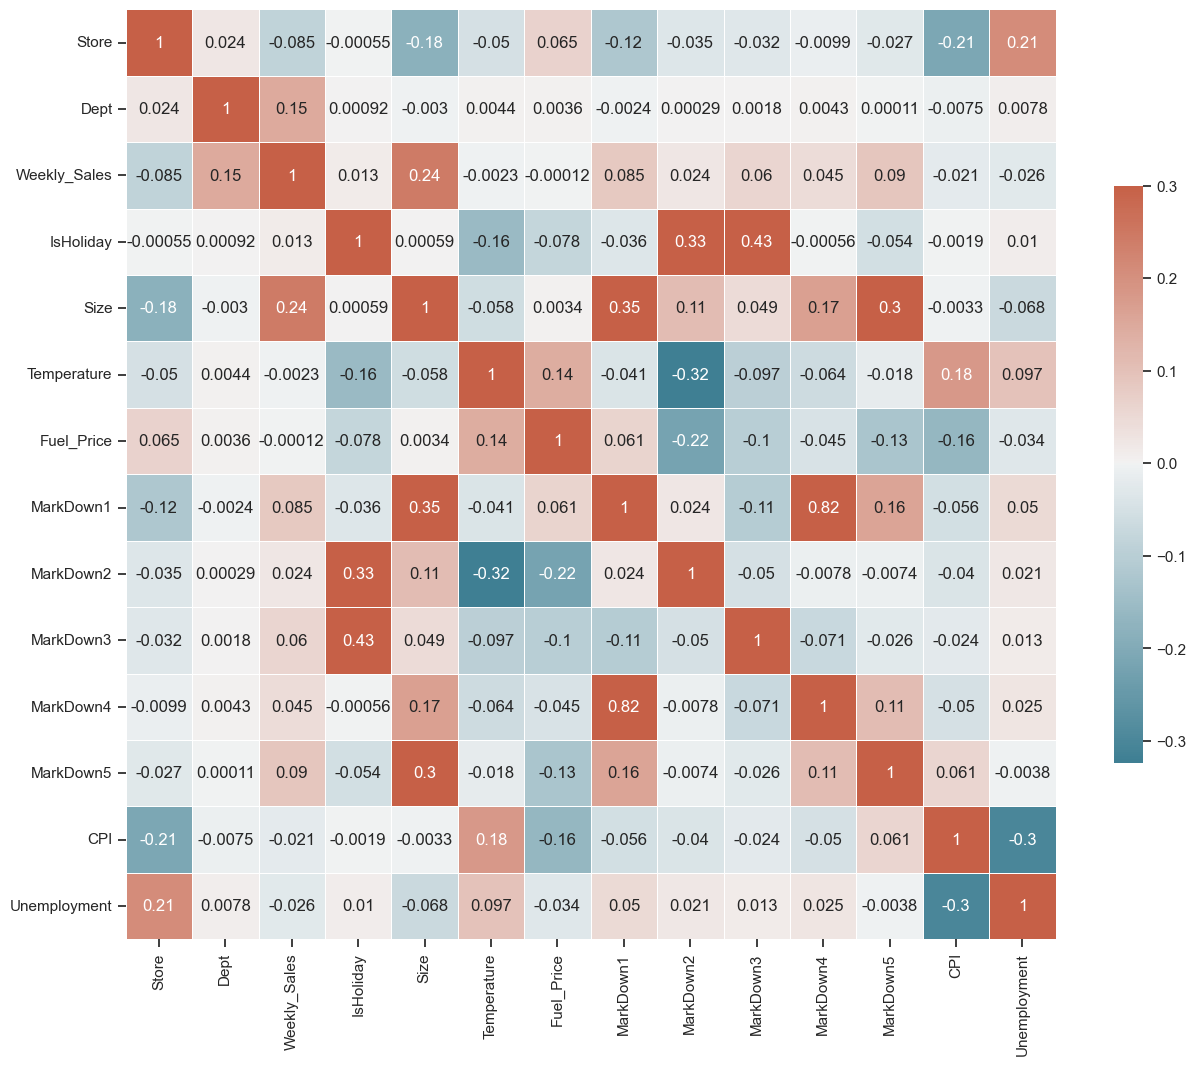

In [6]:
# Feature Correlation plot

corr = dataset.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [7]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Week'] = pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [8]:
df = dataset.pop('Weekly_Sales')
dataset['Weekly_Sales'] = df

In [9]:
input_cols, target_col = dataset.columns[:-1], dataset.columns[-1]
inputs_df, targets = dataset[input_cols].copy(), dataset[target_col].copy()

In [10]:
numeric_cols = dataset[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = dataset[input_cols].select_dtypes(include='object').columns.tolist()

In [11]:
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [13]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

In [14]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

In [15]:
# Train a Random Forest model

rf = RandomForestRegressor(n_estimators=16, random_state = 0, min_samples_leaf = 1)

rf.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=16, random_state=0)

In [16]:
rf_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

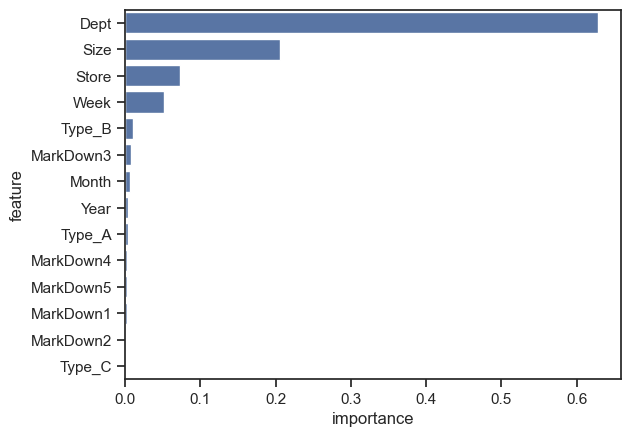

In [17]:
ax = sns.barplot(data=rf_importance_df, x='importance', y='feature')
fig = ax.get_figure()
plt.show()

In [18]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [19]:
sample_input = {'Store':9, 'Dept':72, 'IsHoliday':True, 'Type':'B', 'Size':125833, 'MarkDown1':2.5, 'MarkDown2':0.02, 
                'MarkDown3':55952.99, 'MarkDown4':14.64, 'MarkDown5':310.72, 'Year':2012, 'Month':11, 'Week':47}

In [20]:
predicted_price = predict_input(rf, sample_input)

/Users/neelashasen/Dev/doc/examples/flask/machine-learning/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [21]:
predicted_price

472348.63687500014

In [22]:
walmart_sales_rf = {
    'model': rf,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [23]:
joblib.dump(walmart_sales_rf, 'walmart_sales_rf.joblib')

['walmart_sales_rf.joblib']